# Create annotations for maps using NeuroSynth and neuromaps

# Create annotations for maps using NeuroSynth and neuromaps

- Download neurosynth LDA 50 + convert to MNI152-maps
- Download neurotransmitter maps from neuromaps
- Calculate correlations with both databases using nimare correlationdecoder
- Plot results for both databases

Last update: 2025-02-17, Amelink, J.S.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from nilearn.image import load_img
from nimare.decode.continuous import CorrelationDecoder
from nilearn.datasets import load_mni152_brain_mask 

#paths
ic_data_dir = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/FLICA_multimodal/"
annot_data_dir = os.path.join(ic_data_dir, "neuro_data")
neuromaps_data_dir = os.path.join(annot_data_dir, 'neuromaps')
neurosynth_dir = os.path.join(annot_data_dir, "neurosynth_v7_topic_maps")


In [3]:
# get IC maps
comps = ['5c_c2', '10c_c4']
mods = ['ica_ifl', 'ica_mtl', 'tbm']

ic_map_dict = dict()

for comp in comps:
    for mod in mods:
        
        #load maps
        fn_map = os.path.join(ic_data_dir, "{0}/{1}_000{2}.nii.gz".format(comp, mod, comp[-1]))
        ic_map = load_img(fn_map)
        
        #add to dict
        ic_map_dict["{0}_{1}".format(comp, mod)] = ic_map

In [4]:
#download neurosynth v7
from nimare import dataset, meta, extract
import nimare

download_neurosynth = False

if download_neurosynth:

    files = extract.fetch_neurosynth(
        data_dir=annot_data_dir,  # version 0.0.10 switched to data directory
        version="7",
        overwrite=False,
        source="abstract",
        vocab="LDA50",  # Note the difference here
    )
    neurosynth_db = files[0]

    # Get the Dataset object
    neurosynth_dset = nimare.io.convert_neurosynth_to_dataset(
        coordinates_file=neurosynth_db["coordinates"],
        metadata_file=neurosynth_db["metadata"],
        annotations_files=neurosynth_db["features"],
    )
    neurosynth_dset.save(os.path.join(annot_data_dir, "neurosynth_dataset.pkl.gz"))

    dset = dataset.Dataset.load(os.path.join(annot_data_dir, "neurosynth_dataset.pkl.gz") )

    out_dir = neurosynth_dir

    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)

    # Initialize the Estimator
    meta_estimator = meta.cbma.mkda.MKDAChi2()

    # Get features
    labels = dset.get_labels()
    for label in labels:
        print(f"Processing {label}", flush=True)
        label_positive_ids = dset.get_studies_by_label(label, 0.05)
        label_negative_ids = list(set(dset.ids) - set(label_positive_ids))
        # Require some minimum number of studies in each sample
        if (len(label_positive_ids) == 0) or (len(label_negative_ids) == 0):
            print(f"\tSkipping {label}", flush=True)
            continue

        label_positive_dset = dset.slice(label_positive_ids)
        label_negative_dset = dset.slice(label_negative_ids)
        meta_result = meta_estimator.fit(label_positive_dset, label_negative_dset)
        meta_result.save_maps(output_dir=out_dir, prefix=label)


In [5]:
# neuromaps subcategories
# evo annotations
evo_annots = [('xu2020', 'FChomology', 'fs   lr', '32k'),
              ('xu2020', 'evoexp', 'fsLR', '32k'), 
              ('hill2010', 'devexp', 'fsLR', '164k'), 
              ('hill2010', 'evoexp', 'fsLR', '164k')]

#gene annotations
gene_annots = [('abagen', 'genepc1', 'fsaverage', '10k')]

# PET annotations
pet_annots = [
# Acetylcholine
('aghourian2017', 'feobv', 'MNI152', '1mm'), #  (SUVR) to VAChT (acetylcholine transporter)
('bedard2019', 'feobv', 'MNI152', '1mm'), #  (SUVR) to VAChT (acetylcholine transporter)
('hillmer2016', 'flubatine', 'MNI152', '1mm'), # (Vt) to a4b2 (acetylcholine receptor)
('naganawa2020', 'lsn3172176', 'MNI152', '1mm'), #  (BPnd) to M1 (acetylcholine receptor)
('tuominen', 'feobv', 'MNI152', '2mm'), # (SUVR) to VAChT (acetylcholine transporter)

# Cannabinoid
('laurikainen2018', 'fmpepd2', 'MNI152', '1mm'), # (Vt) to CB1 (cannabinoid receptor)
('normandin2015', 'omar', 'MNI152', '1mm'), #  (Vt) to CB1 (cannabinoid receptor)

# Dopamine
('alarkurtti2015', 'raclopride', 'MNI152', '3mm'), #  (BPnd) to D2 (dopamine receptor)
('dukart2018', 'fpcit', 'MNI152', '3mm'), #  SPECT (SUVR) to DAT (dopamine transporter)
('jaworska2020', 'fallypride', 'MNI152', '1mm'), # (BPnd) to D2 (dopamine receptor)
('kaller2017', 'sch23390', 'MNI152', '3mm'), # (BPnd) to D1 (dopamine receptor)
('malen2022', 'raclopride', 'MNI152', '2mm'), # (BPnd) to D2 (dopamine receptor)
('sandiego2015', 'flb457', 'MNI152', '1mm'), # (BPnd) to D2 (dopamine receptor)
('sasaki2012', 'fepe2i', 'MNI152', '1mm'), #  (BPnd) to DAT (dopamine transporter)
('smith2017', 'flb457', 'MNI152', '1mm'), #  (BPnd) to D2 (dopamine receptor)

# Serotonin
('beliveau2017', 'az10419369', 'MNI152', '1mm'), # (Bmax) to 5-HT1B (serotonin receptor) 
('beliveau2017', 'cimbi36', 'MNI152', '1mm'), # (Bmax) to 5-HT2A (serotonin receptor)
('beliveau2017', 'cumi101', 'MNI152', '1mm'), # (Bmax) to 5-HT1A (serotonin receptor)
('beliveau2017', 'dasb', 'MNI152', '1mm'), # (Bmax) to SERT (serotonin transporter)
('beliveau2017', 'sb207145', 'MNI152', '1mm'), # (Bmax) to 5-HT4 (serotonin receptor)
('fazio2016', 'madam', 'MNI152', '3mm'), # (BPnd) to 5-HTT (serotonin transporter)
('gallezot2010', 'p943', 'MNI152', '1mm'), # (BPnd) to 5-HT1b (serotonin receptor)
('radnakrishnan2018', 'gsk215083', 'MNI152', '1mm'), # (BPnd) to 5-HT6 (serotonin receptor)
('savli2012', 'altanserin', 'MNI152', '3mm'), # (BPnd) to 5-HT2a (serotonin receptor)
('savli2012', 'dasb', 'MNI152', '3mm'), #  (BPnd) to 5-HTT (serotonin transporter)
('savli2012', 'p943', 'MNI152', '3mm'), # (BPnd) to 5-HT1b (serotonin receptor)
('savli2012', 'way100635', 'MNI152', '3mm'), # (BPnd) to 5-HT1a (serotonin receptor)

# GABA
('dukart2018', 'flumazenil', 'MNI152', '3mm'), # (BPnd) to GABA-A (GABA receptor)
('lukow2022', 'ro154513', 'MNI152', '2mm'), # (BPnd) to GABAa receptor, alpha5 subunit
('norgaard2021', 'flumazenil', 'MNI152', '1mm'), # GABAa benzodiazepine binding-site density (Bmax; gaba receptor)

# Glutamate
('lois2018', 'pbr28', 'MNI152', '2mm'), #  (SUVR) to TSPO (translocator protein)
('rosaneto', 'abp688', 'MNI152', '1mm'), # (BPnd) to mGluR5 (glutamate receptor)
('smart2019', 'abp688', 'MNI152', '1mm'), # (BPnd) to mGluR5 (glutamate receptor)
('galovic2021', 'ge179', 'MNI152', '1mm'), #  (Vt) to NMDA (glutamate receptor)
('dubois2015', 'abp688', 'MNI152', '1mm'), #  (BPnd) to mGluR5 (glutamate receptor)

# Opioid
('kantonen2020', 'carfentanil', 'MNI152', '3mm'),  #  (BPnd) to MOR (mu-opioid receptor)
('turtonen2020', 'carfentanil', 'MNI152', '1mm'), #  (BPnd) to MOR (mu-opioid receptor)
('vijay2018', 'ly2795050', 'MNI152', '2mm'), #  (Vt) to KOR (kappa-opioid receptor)

# Norepinephrine
('ding2010', 'mrb', 'MNI152', '1mm'), # (BPnd) to NET (norepinephrine transporter)

# Metabolism
('castrillon2023', 'cmrglc', 'MNI152', '3mm'), # (CMRglc) to glucose metabolism
#('raichle', 'cmrglc', 'fsLR', '164k'), # glucose metabolism
#('raichle', 'cmr02', 'fsLR', '164k'), # oxygen metabolism

#blood flow
#('raichle', 'cbf', 'fsLR', '164k'), # cerebral blood flow
#('raichle', 'cbv', 'fsLR', '164k'), # cerebral blood volume

#Other biology
('finnema2016', 'ucbj', 'MNI152', '1mm'), #  (BPnd) to SV2A (synaptic vesicle glycoprotein 2A, a synapse marker)
('gallezot2017', 'gsk189254', 'MNI152', '1mm'), #  (Vt) to H3 (histamine receptor)
('kim2020', 'ps13', 'MNI152', '2mm'), # (Vt) to COX-1 (cyclooxygenase-1) 
('wey2016', 'martinostat', 'MNI152', '2mm') # (SUVR) to class 1 HDAC isoforms 1, 2, and 3 (histone deacetylase)
]

# neuroimaging annotations
meg_annots = [
    # MEG
('hcps1200', 'megalpha', 'fsLR', '4k'), # MEG alpha power
('hcps1200', 'megbeta', 'fsLR', '4k'), # MEG beta power
('hcps1200', 'megdelta', 'fsLR', '4k'), # MEG delta power
('hcps1200', 'meggamma1', 'fsLR', '4k'), # MEG gamma1 power
('hcps1200', 'meggamma2', 'fsLR', '4k'), # MEG gamma2 power
('hcps1200', 'megtheta', 'fsLR', '4k'),    # MEG theta power
('hcps1200', 'megtimescale', 'fsLR', '4k'), # MEG timescale
] 

mri_annots = [ 
# functional gradients
('margulies2016', 'fcgradient01', 'fsLR', '32k'),
('margulies2016', 'fcgradient02', 'fsLR', '32k'),
('margulies2016', 'fcgradient03', 'fsLR', '32k'),
('margulies2016', 'fcgradient04', 'fsLR', '32k'),
('margulies2016', 'fcgradient05', 'fsLR', '32k'),
('margulies2016', 'fcgradient06', 'fsLR', '32k'),
('margulies2016', 'fcgradient07', 'fsLR', '32k'),
('margulies2016', 'fcgradient08', 'fsLR', '32k'),
('margulies2016', 'fcgradient09', 'fsLR', '32k'),
('margulies2016', 'fcgradient10', 'fsLR', '32k'),

# structural maps
('hcps1200', 'myelinmap', 'fsLR', '32k'), # myelin map
('hcps1200', 'thickness', 'fsLR', '32k'), # cortical thickness
('mueller2013', 'intersubjvar', 'fsLR', '164k'),
('reardon2018', 'scalinghcp', 'civet', '41k'),
('reardon2018', 'scalingnih', 'civet', '41k'),
('reardon2018', 'scalingpnc', 'civet', '41k'), 

# others
('sydnor2021', 'SAaxis', 'fsLR', '32k'),
('neurosynth', 'cogpc1', 'MNI152', '2mm'),
('satterthwaite2014', 'meancbf', 'MNI152', '1mm')
]

use_annots =  pet_annots #+ meg_annots + evo_annots + gene_annots # + mri_annots

In [6]:
# if not downloaded, trial and error until failed is empty. Throws HTTPError after 2-3 downloads. Rinse repeat.
from neuromaps.datasets import fetch_annotation

download_neuromaps = False

if download_neuromaps:

    failed = []

    for annot in use_annots:
        try: 
            fetch_annotation(source = annot[0],
                            desc = annot[1],
                            space = annot[2],
                            den = annot[3],
                            data_dir=neuromaps_data_dir,
                            verbose=True)
        except:
            failed.append(annot)

In [7]:
# NEUROSYNTH DICT + CATEGORIES

nsynth_maps = sorted(glob.glob(os.path.join(neurosynth_dir, '*z_desc-association.nii.gz')))

lang_related = ["Language lateralization", "Auditory/speech", "Language and reading", "Semantic representations"]
main_networks = ["Default mode", "Salience", "Multiple demands", "Cognitive control", "Executive control", "Attention"]
emotional = ["Anxiety", "Negative mood", "Stress", "Depression", "Pain"]
memory = ["Working memory", "Memory retrieval encoding", "Learning", "Fear conditioning", "Priming", "Sleep"]
reward_processing = ["Placebo", "Reward",  "Taste and food"]
social_cognition = ["Theory of mind", "Empathy"]
cognitive = ["Thinking/creativity", "Decision making",  "Face processing", "Mental imagery", "Arithmetic"]
disorders = ["ASD", "ADHD", "Schizophrenia", "Dementia", "Blindness" ]
sensorimotor = ["Visuospatial", "Sensorimotor", "Spatial orientation", "Motion perception", "Motor control", "Cerebellar function", "Response inhibition"]
other = ["Sex differences", "Structural", "Methodological", "Adolescence", "Oscillations", "TMS", "Magnetic mechanisms humans"]

#labels
labels_all_cats = ["Language", "Emotion", "Memory", "Reward", "Social cognition", "Cognitive", "Disorders", "Sensorimotor", "Main networks", "Other"]
labels_all = lang_related + emotional + memory + reward_processing + social_cognition + cognitive + disorders + sensorimotor + main_networks + other
print(len(labels_all_cats), len(labels_all))

# labels:
nsynth_dict = {"0":"Default mode",
              "1": "Anxiety",
              "2": "Cerebellar function",
              "3":  "Salience",
              "4": "Priming",
              "5": "Visuospatial",
              "6": "Auditory/speech",
              "7": "Reward",
                "8": "Theory of mind",
                "9": "Working memory",
                "10": "Taste and food",
                "11": "Learning",
                "12": "Sex differences",
                "13": "Fear conditioning",
                "14": "Dementia",
                "15": "Multiple demands",
                "16": "Response inhibition",
                "17": "Sensorimotor",
                "18": "Arithmetic",
                "19": "Motor control",
                "20": "Cognitive control",
                "21": "Structural",
                "22": "Methodological",
                "23": "ASD", #or fluid intelligence
                "24": "Adolescence",
                "25": "Spatial orientation",
                "26": "Negative mood",
                "27": "ADHD", #or attention/hyperactivity
                "28": "Empathy",
                "29": "Stress",
                "30": "Decision making",
                "31": "Thinking/creativity",
                "32": "Pain",
                "33": "Memory retrieval encoding",
                "34": "Oscillations",
                "35": "Schizophrenia",
                "36": "Placebo",
                "37": "Language and reading",
                "38": "Semantic representations",
                "39": "TMS",
                "40": "Face processing",
                "41": "Mental imagery",
                "42": "Blindness",
                "43": "Magnetic mechanisms humans",
                "44": "Sleep",
                "45": "Motion perception",
                "46": "Language lateralization",
                "47": "Attention",
                "48": "Executive control",
                "49": "Depression"} 

nsynth_fn_dict = {nsynth_dict[os.path.split(fn)[-1].split("__")[1].split("_")[0]]: fn for fn in nsynth_maps}

print(nsynth_fn_dict)


10 50
{'Default mode': 'C:\\Users\\Jitse\\OneDrive\\Work\\03_UKB_FLICA\\neuro_data\\neurosynth_v7_topic_maps\\LDA50_abstract_weight__0_network_state_resting_z_desc-association.nii.gz', 'Taste and food': 'C:\\Users\\Jitse\\OneDrive\\Work\\03_UKB_FLICA\\neuro_data\\neurosynth_v7_topic_maps\\LDA50_abstract_weight__10_food_taste_weight_z_desc-association.nii.gz', 'Learning': 'C:\\Users\\Jitse\\OneDrive\\Work\\03_UKB_FLICA\\neuro_data\\neurosynth_v7_topic_maps\\LDA50_abstract_weight__11_learning_training_practice_z_desc-association.nii.gz', 'Sex differences': 'C:\\Users\\Jitse\\OneDrive\\Work\\03_UKB_FLICA\\neuro_data\\neurosynth_v7_topic_maps\\LDA50_abstract_weight__12_women_men_sex_z_desc-association.nii.gz', 'Fear conditioning': 'C:\\Users\\Jitse\\OneDrive\\Work\\03_UKB_FLICA\\neuro_data\\neurosynth_v7_topic_maps\\LDA50_abstract_weight__13_fear_threat_smokers_z_desc-association.nii.gz', 'Dementia': 'C:\\Users\\Jitse\\OneDrive\\Work\\03_UKB_FLICA\\neuro_data\\neurosynth_v7_topic_maps\\LDA

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
C:\Users\Jitse\AppData\Local\Temp\ipykernel_15512\4063375390.py:33: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled = resample_to_img(pet_img, template)
c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
C:\Users\Jitse\AppData\Local\Temp\ipykernel_15512\4063375390.py:33: FutureWarning:

(69765, 3)
[22. 73. 28.]


C:\Users\Jitse\AppData\Local\Temp\ipykernel_15512\4063375390.py:33: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled = resample_to_img(pet_img, template)
c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
C:\Users\Jitse\AppData\Local\Temp\ipykernel_15512\4063375390.py:33: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled = resample_to_img(pet_img, template)
c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwar

(69765, 2)
[37. 55.]


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
C:\Users\Jitse\AppData\Local\Temp\ipykernel_15512\4063375390.py:33: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled = resample_to_img(pet_img, template)
c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.globa

(69765, 3)
[18.  5.  4.]


C:\Users\Jitse\AppData\Local\Temp\ipykernel_15512\4063375390.py:33: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled = resample_to_img(pet_img, template)
c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
C:\Users\Jitse\AppData\Local\Temp\ipykernel_15512\4063375390.py:33: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled = resample_to_img(pet_img, template)
c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwar

(69765, 2)
[23. 19.]


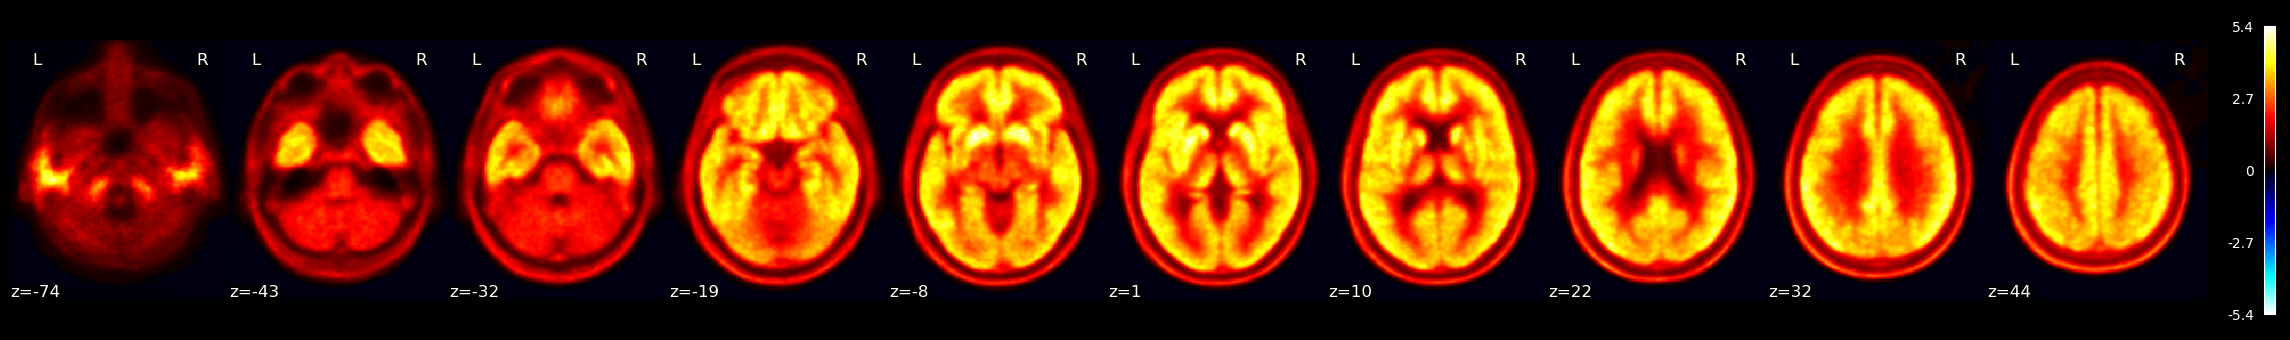

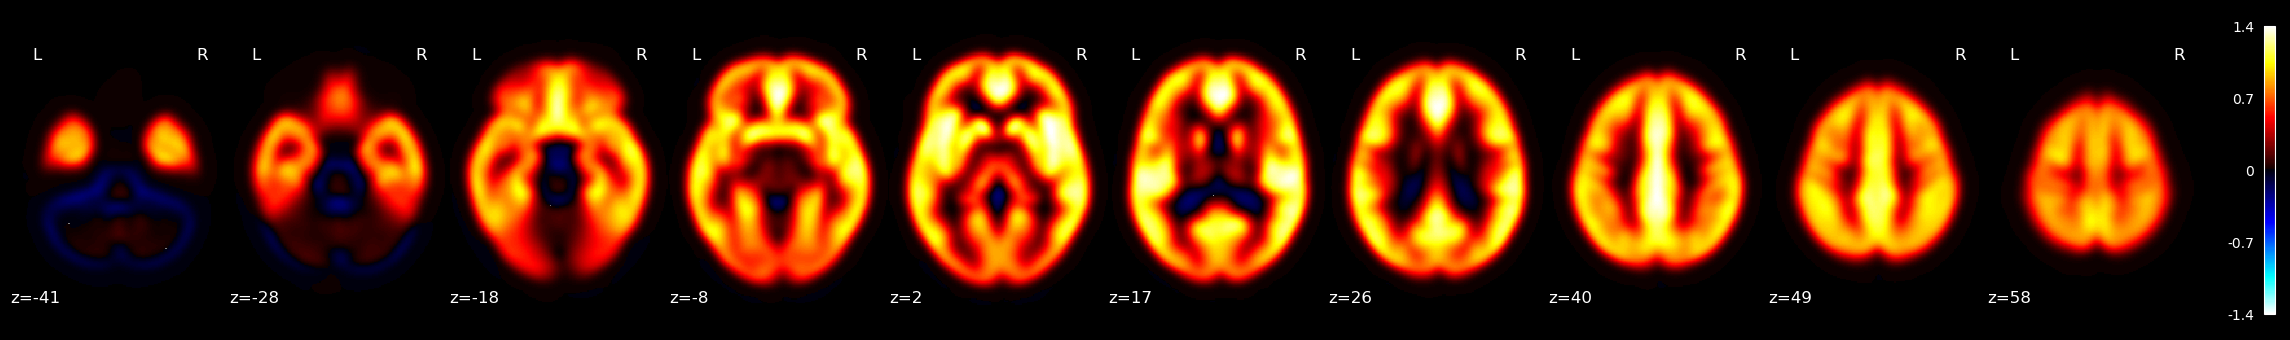

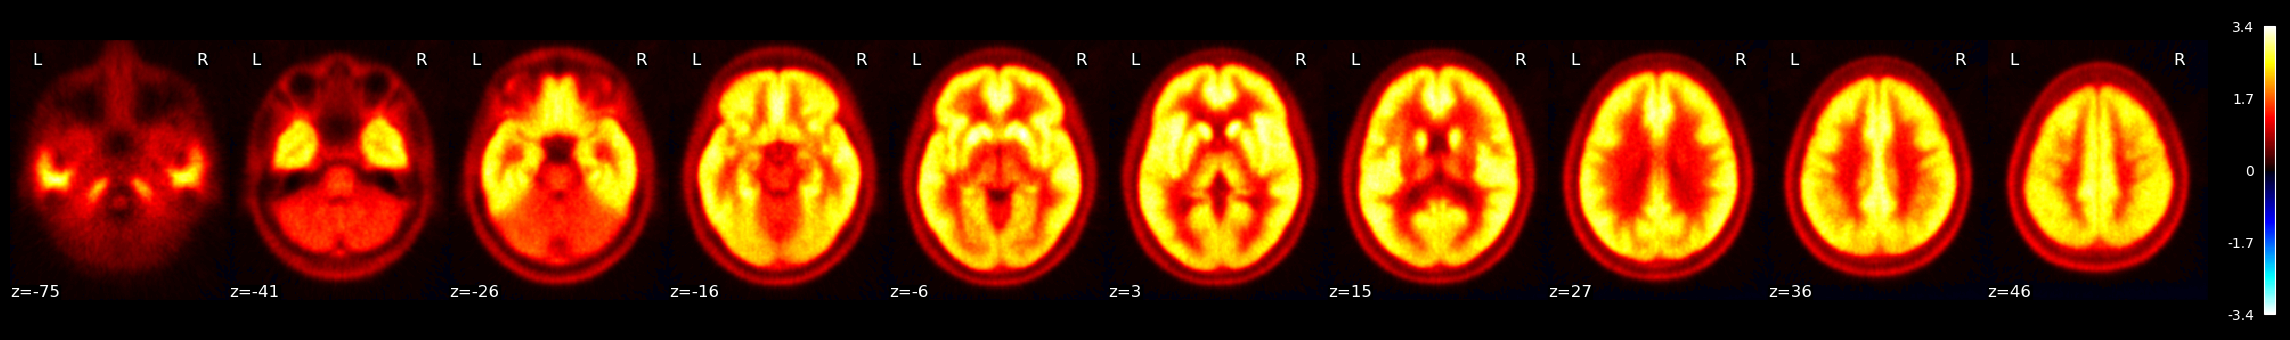

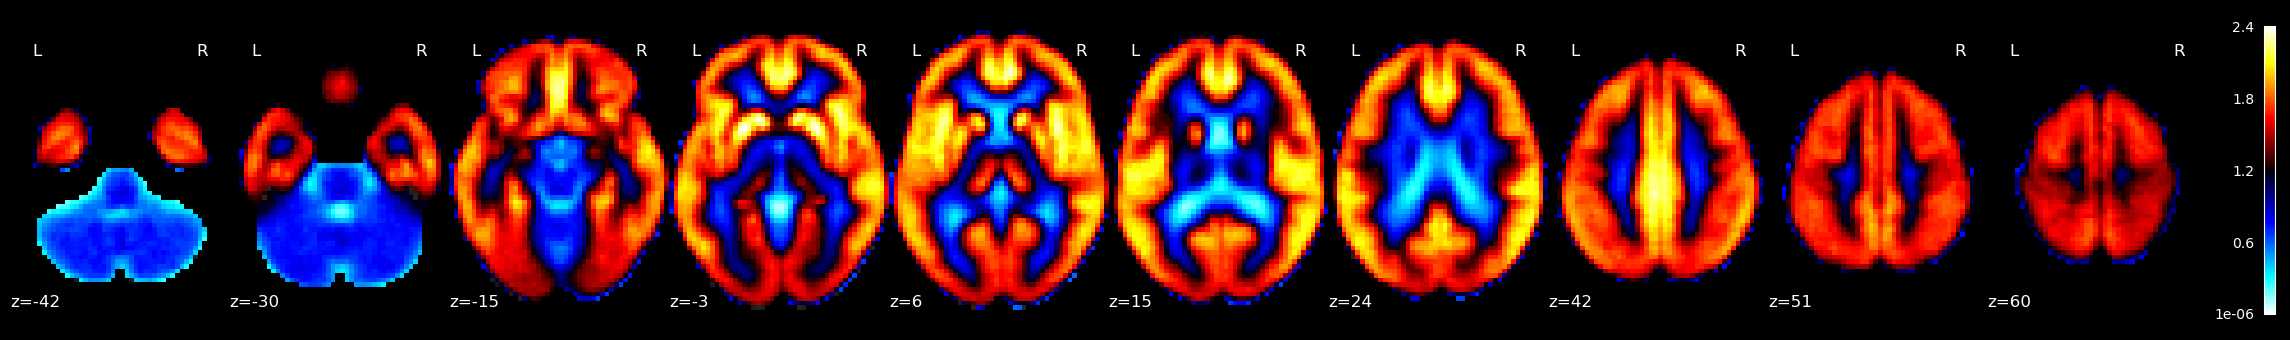

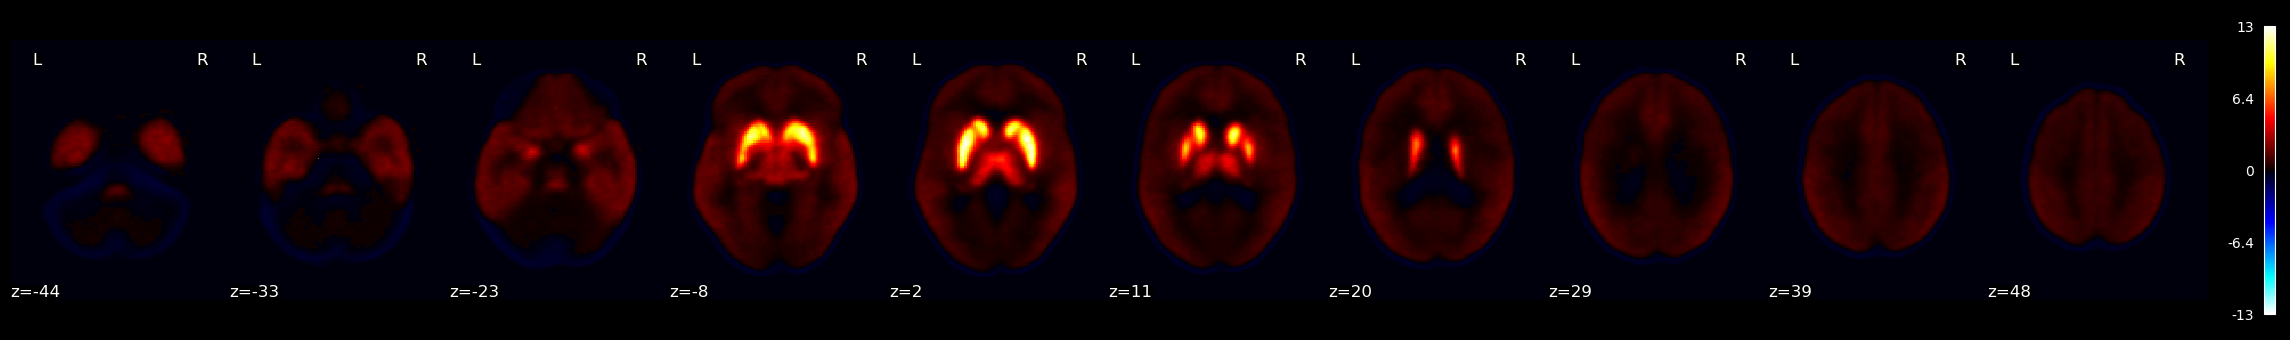

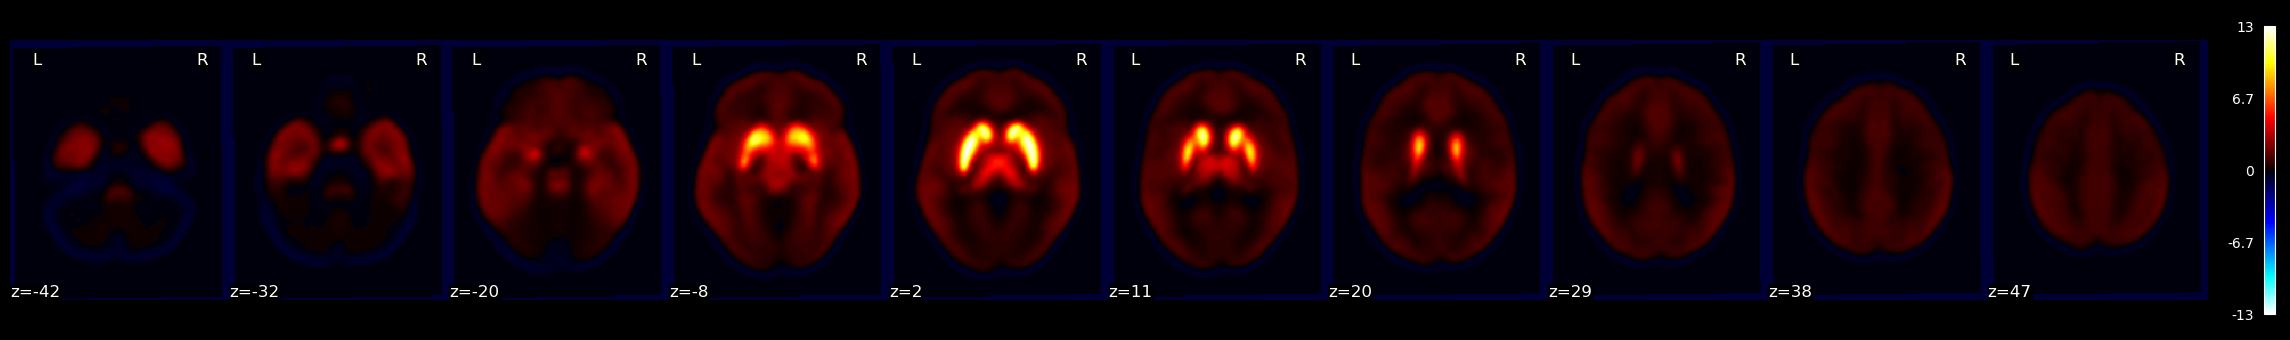

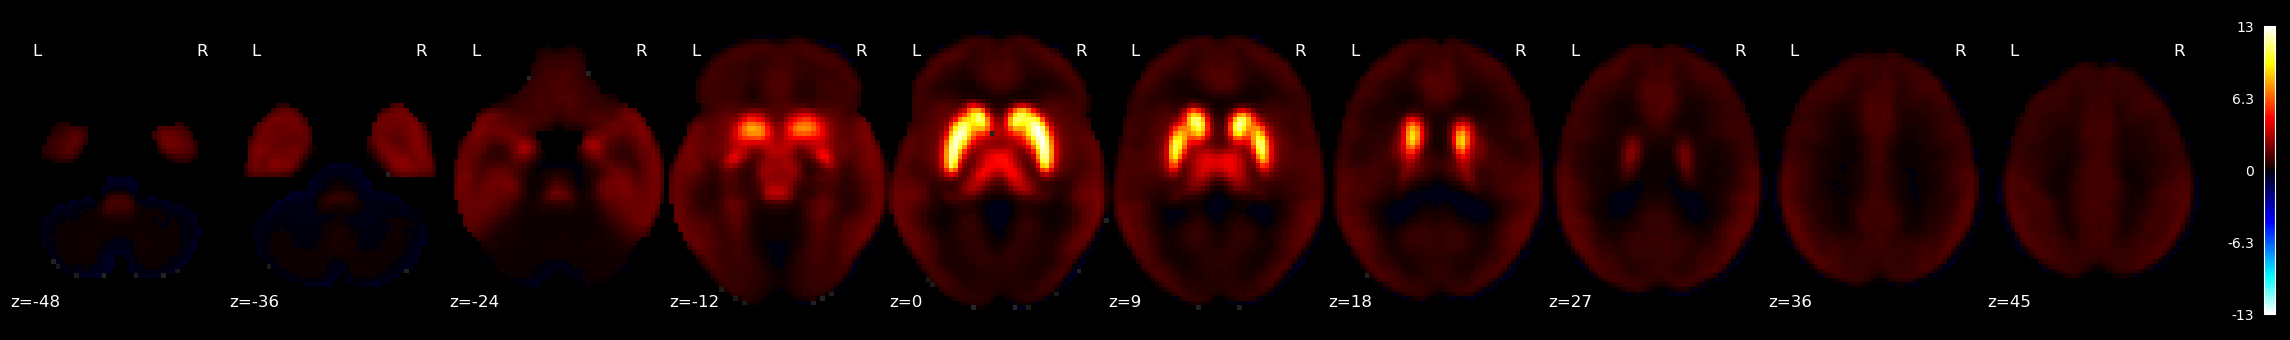

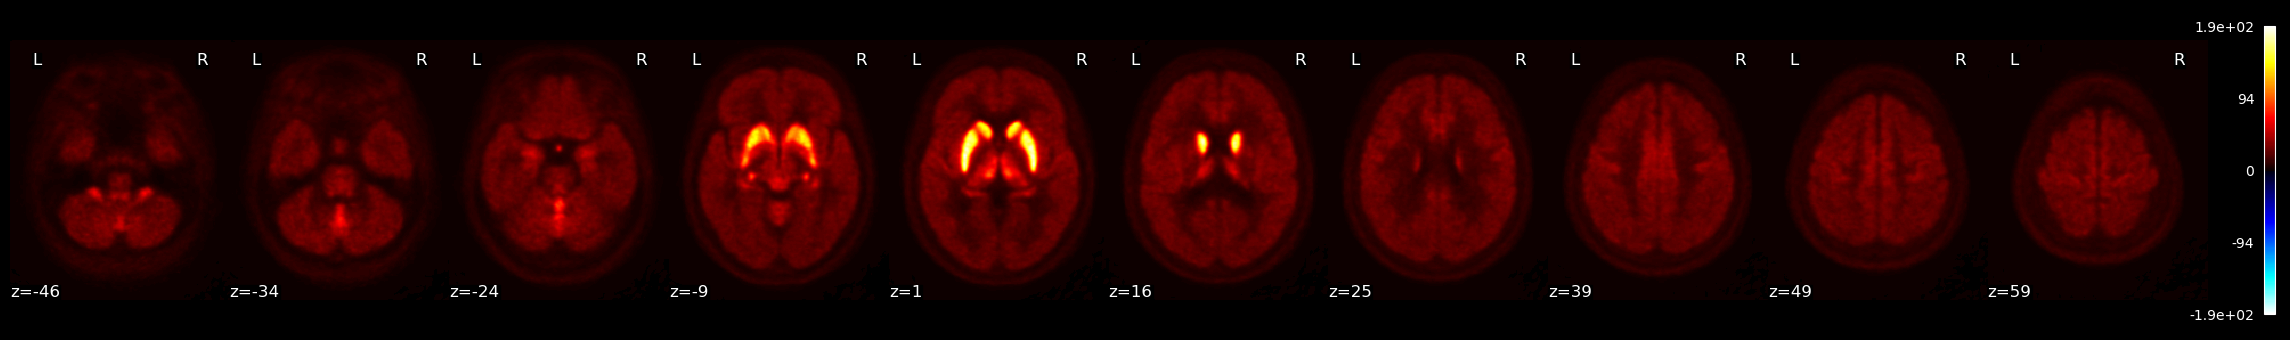

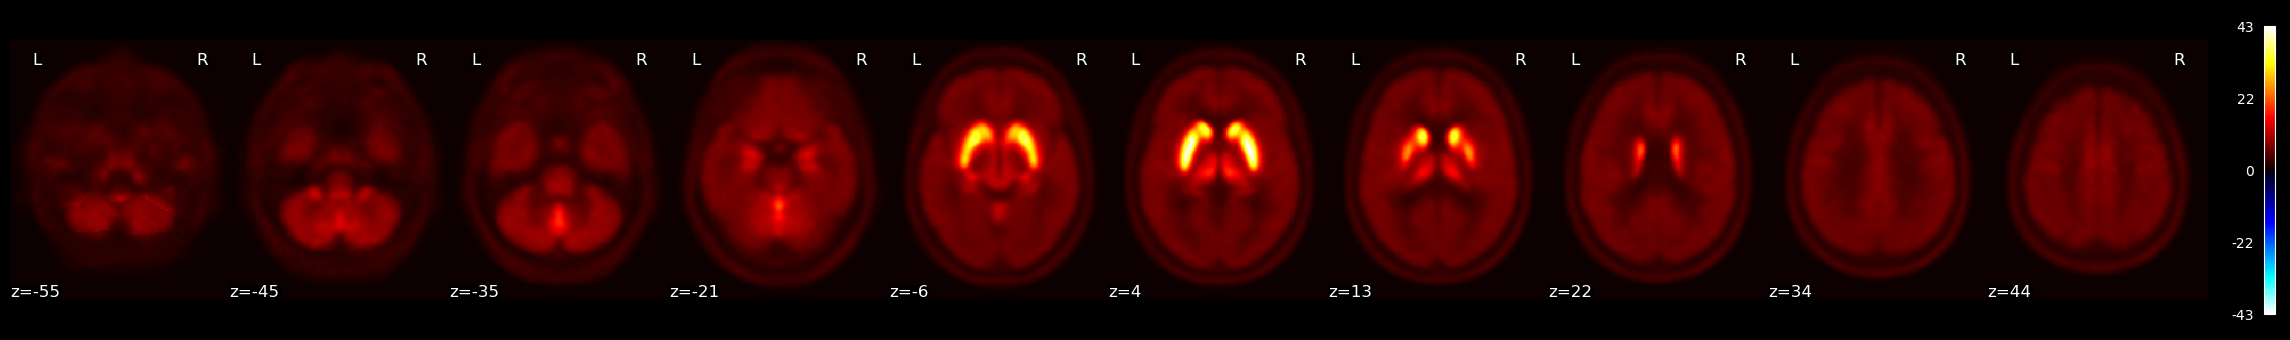

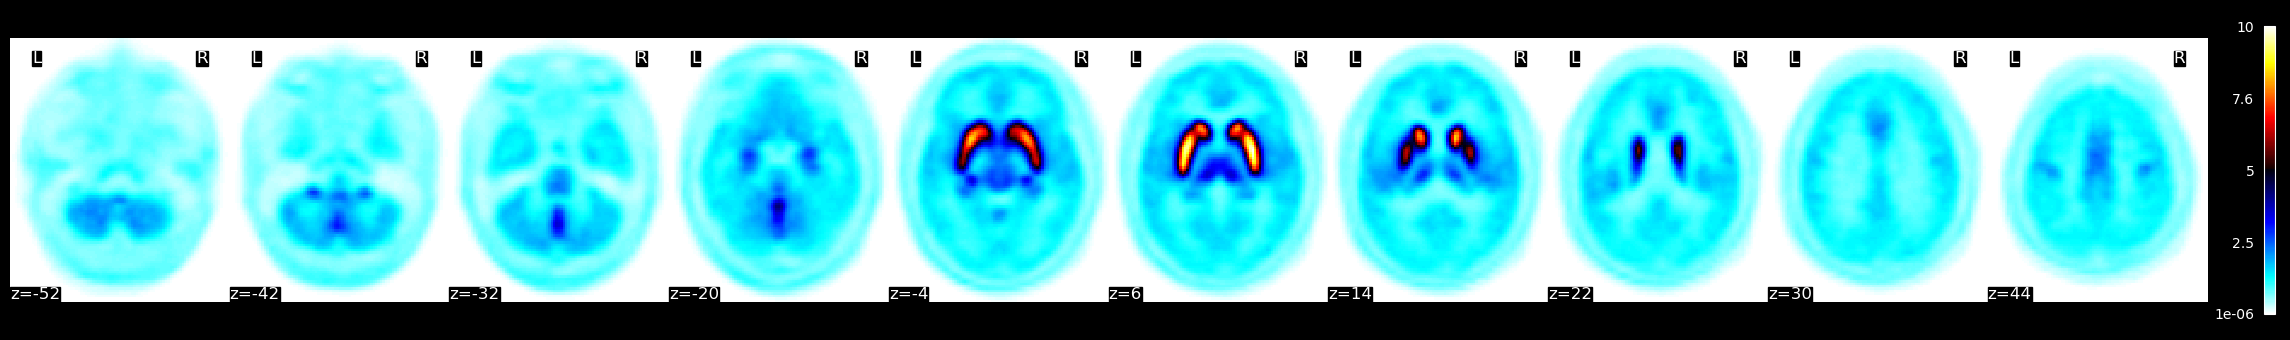

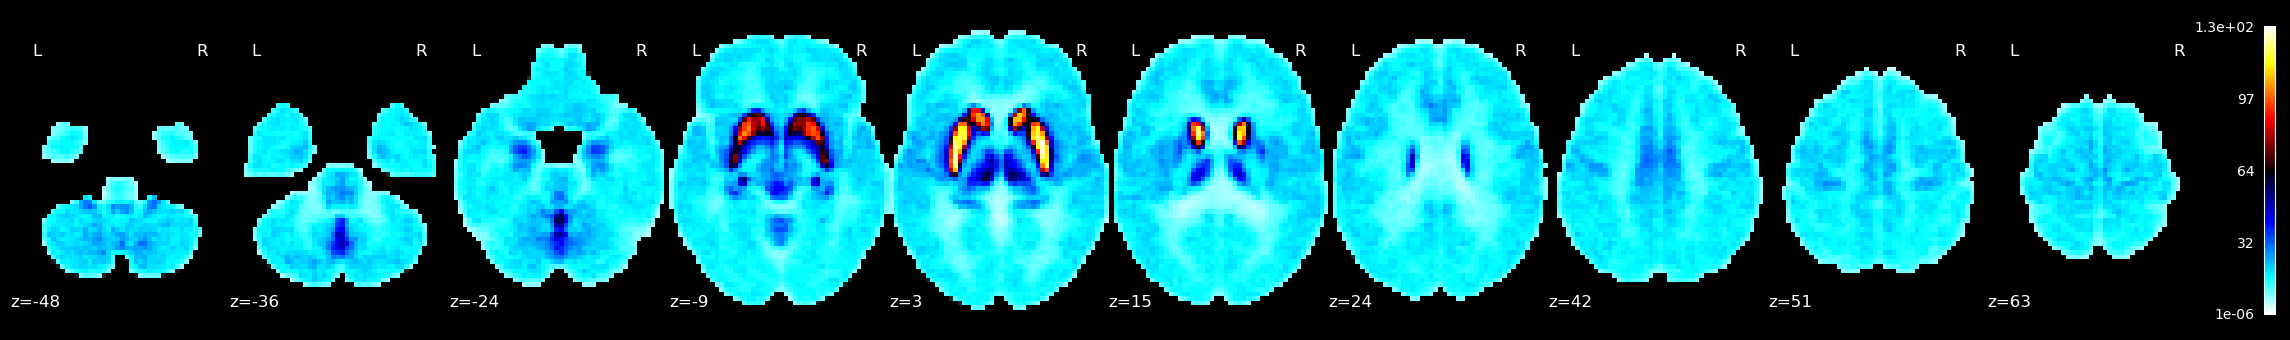

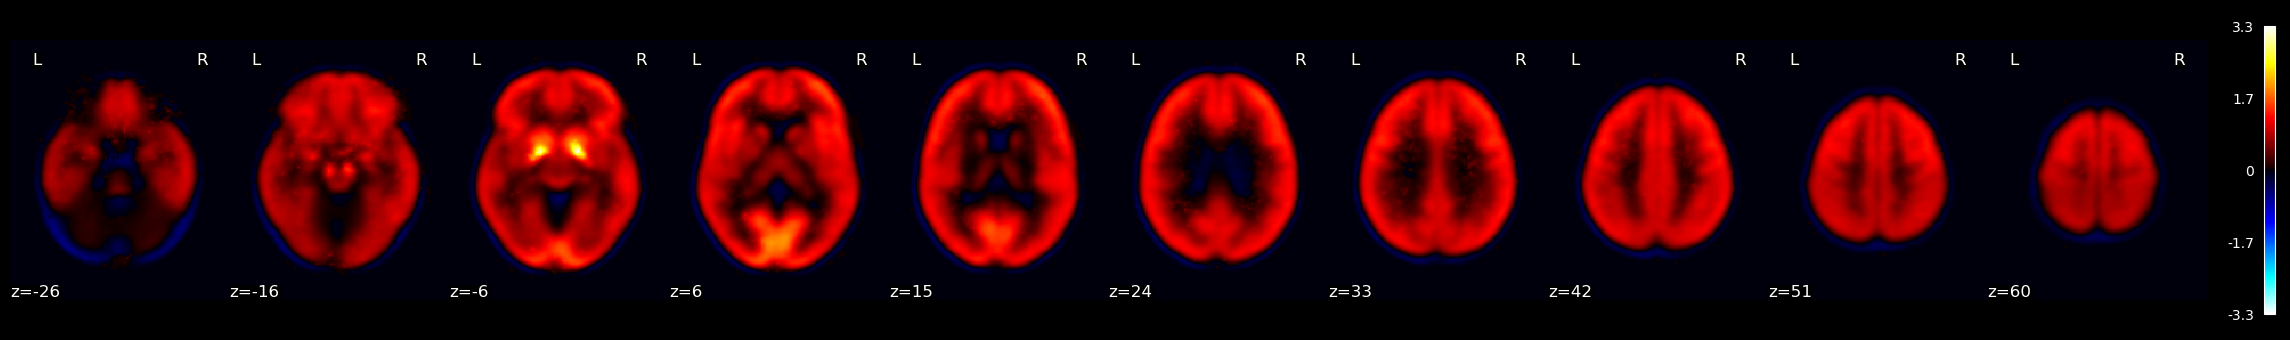

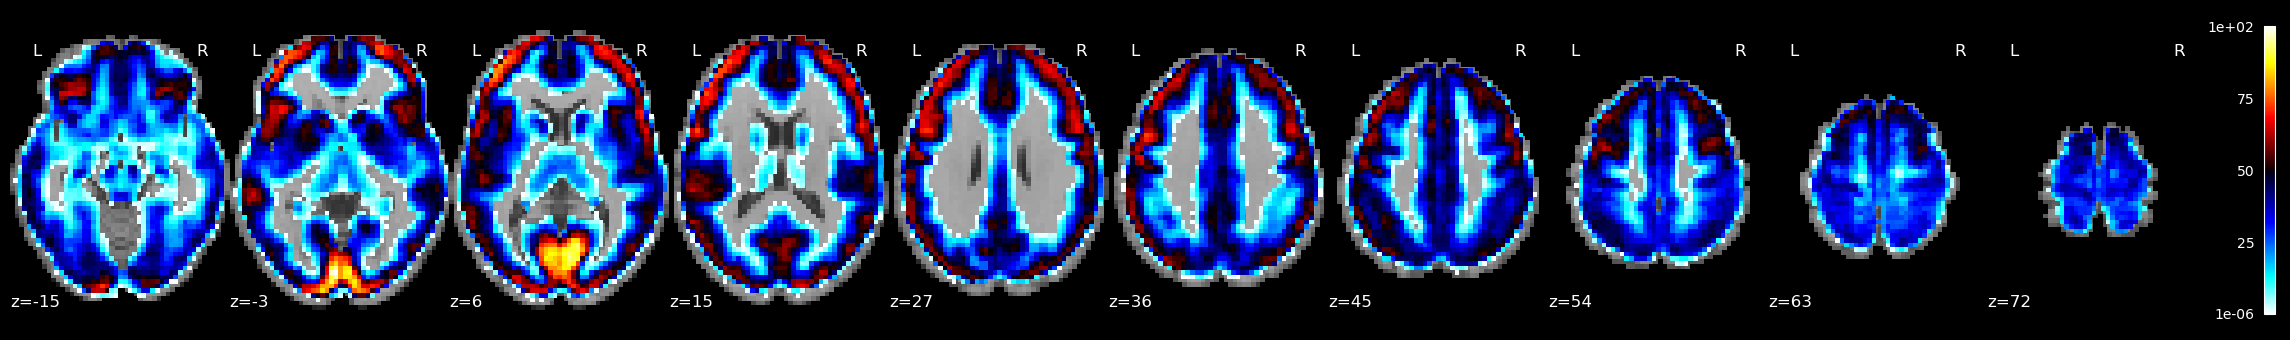

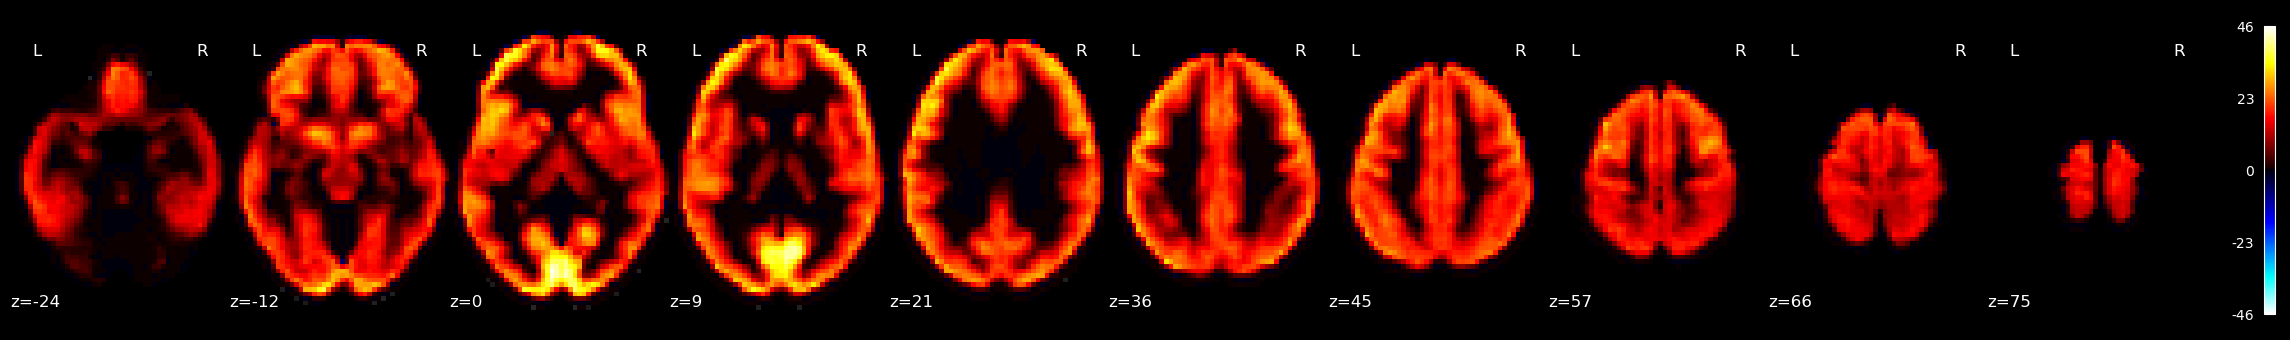

In [8]:
from nilearn.masking import apply_mask
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.image import resample_to_img, new_img_like
from nilearn.masking import unmask
from nilearn.plotting import plot_stat_map
import nibabel as nib

fn = r"C:\Users\Jitse\OneDrive\Work\03_UKB_FLICA\neuro_data\neuromaps\annotations\{0}\{1}\{2}\source-{0}_desc-{1}_space-{2}_res-{3}_feature.nii.gz"
fn_avg = r"C:\Users\Jitse\OneDrive\Work\03_UKB_FLICA\neuro_data\neuromaps\annotations_avg\{0}.nii.gz"

doubles_lsts = [

[('rosaneto', 'abp688', 'MNI152', '1mm', 22), ('smart2019', 'abp688', 'MNI152', '1mm', 73), ('dubois2015', 'abp688', 'MNI152', '1mm', 28)],
[('smith2017', 'flb457', 'MNI152', '1mm', 37), ('sandiego2015', 'flb457', 'MNI152', '1mm', 55)],
[ ('aghourian2017', 'feobv', 'MNI152', '1mm', 18), ('bedard2019', 'feobv', 'MNI152', '1mm', 5), ('tuominen', 'feobv', 'MNI152', '2mm', 4) ],
[('gallezot2010', 'p943', 'MNI152', '1mm', 23), ('savli2012', 'p943', 'MNI152', '3mm', 19)]

]

mask = load_mni152_brain_mask(resolution=3)
template = load_mni152_template(resolution=3)

# TAKE AVERAGE (SEE HANSEN ET AL)
for db_lst in doubles_lsts:
    data_lst = []
    
    for annot in db_lst:
        #read each pet map per tracer
        pet_img = load_img(fn.format(annot[0], annot[1], annot[2], annot[3]))
        plot_stat_map(fn.format(annot[0], annot[1], annot[2], annot[3]), bg_img=template, cut_coords=10, display_mode='z')

        #Downsample to 3mm
        resampled = resample_to_img(pet_img, template)

        #extract within MNI
        masked_data = apply_mask(resampled, mask)

        #append
        data_lst.append(masked_data)

    #put data in array
    data = np.zeros((masked_data.shape[0], len(data_lst)))
    for i in range(len(data_lst)):
        data[:,i] = data_lst[i]
    print(data.shape)

    #get weights for weighted avg
    weights = np.zeros(len(db_lst))
    for i in range(len(db_lst)):
        weights[i] = db_lst[i][4]
    print(weights)

    #take weighted avg
    weighted_avg = np.average(data, axis=1, weights=weights)

    #put back in mask, save + plot
    avg_img = unmask(weighted_avg, mask)
    nib.save(avg_img, fn_avg.format(db_lst[0][1]))
    plot_stat_map(avg_img, bg_img=template, cut_coords=10, display_mode='z')


In [9]:
# PET DICT + CATEGORIES
pet_annots = [
# Acetylcholine
#('aghourian2017', 'feobv', 'MNI152', '1mm'), #  (SUVR) to VAChT (acetylcholine transporter)
#('bedard2019', 'feobv', 'MNI152', '1mm'), #  (SUVR) to VAChT (acetylcholine transporter)
('hillmer2016', 'flubatine', 'MNI152', '1mm'), # (Vt) to a4b2 (acetylcholine receptor)
('naganawa2020', 'lsn3172176', 'MNI152', '1mm'), #  (BPnd) to M1 (acetylcholine receptor)
#('tuominen', 'feobv', 'MNI152', '2mm'), # (SUVR) to VAChT (acetylcholine transporter)

# Cannabinoid
('laurikainen2018', 'fmpepd2', 'MNI152', '1mm'), # (Vt) to CB1 (cannabinoid receptor)
('normandin2015', 'omar', 'MNI152', '1mm'), #  (Vt) to CB1 (cannabinoid receptor)

# Dopamine
('dukart2018', 'fpcit', 'MNI152', '3mm'), #  SPECT (SUVR) to DAT (dopamine transporter)
('jaworska2020', 'fallypride', 'MNI152', '1mm'), # (BPnd) to D2 (dopamine receptor)
('kaller2017', 'sch23390', 'MNI152', '3mm'), # (BPnd) to D1 (dopamine receptor)
#('smith2017', 'flb457', 'MNI152', '1mm'), #  (BPnd) to D2 (dopamine receptor)
#('sandiego2015', 'flb457', 'MNI152', '1mm'), # (BPnd) to D2 (dopamine receptor)
('sasaki2012', 'fepe2i', 'MNI152', '1mm'), #  (BPnd) to DAT (dopamine transporter)

#UNRELIABLE
#('malen2022', 'raclopride', 'MNI152', '2mm'), # (BPnd) to D2 (dopamine receptor)
#('alarkurtti2015', 'raclopride', 'MNI152', '3mm'), #  (BPnd) to D2 (dopamine receptor)

# Serotonin
('beliveau2017', 'az10419369', 'MNI152', '1mm'), # (Bmax) to 5-HT1B (serotonin receptor) 
('beliveau2017', 'cimbi36', 'MNI152', '1mm'), # (Bmax) to 5-HT2A (serotonin receptor)
('beliveau2017', 'cumi101', 'MNI152', '1mm'), # (Bmax) to 5-HT1A (serotonin receptor)
('beliveau2017', 'dasb', 'MNI152', '1mm'), # (Bmax) to SERT (serotonin transporter)
('beliveau2017', 'sb207145', 'MNI152', '1mm'), # (Bmax) to 5-HT4 (serotonin receptor)
('fazio2016', 'madam', 'MNI152', '3mm'), # (BPnd) to 5-HTT (serotonin transporter)
#('gallezot2010', 'p943', 'MNI152', '1mm'), # (BPnd) to 5-HT1b (serotonin receptor)
('radnakrishnan2018', 'gsk215083', 'MNI152', '1mm'), # (BPnd) to 5-HT6 (serotonin receptor)
('savli2012', 'altanserin', 'MNI152', '3mm'), # (BPnd) to 5-HT2a (serotonin receptor)
('savli2012', 'dasb', 'MNI152', '3mm'), #  (BPnd) to 5-HTT (serotonin transporter)
#('savli2012', 'p943', 'MNI152', '3mm'), # (BPnd) to 5-HT1b (serotonin receptor)
('savli2012', 'way100635', 'MNI152', '3mm'), # (BPnd) to 5-HT1a (serotonin receptor)

# GABA
('dukart2018', 'flumazenil', 'MNI152', '3mm'), # (BPnd) to GABA-A (GABA receptor)
('lukow2022', 'ro154513', 'MNI152', '2mm'), # (BPnd) to GABAa receptor, alpha5 subunit
('norgaard2021', 'flumazenil', 'MNI152', '1mm'), # GABAa benzodiazepine binding-site density (Bmax; gaba receptor)

# Glutamate
('lois2018', 'pbr28', 'MNI152', '2mm'), #  (SUVR) to TSPO (translocator protein)
#('rosaneto', 'abp688', 'MNI152', '1mm'), # (BPnd) to mGluR5 (glutamate receptor)
#('smart2019', 'abp688', 'MNI152', '1mm'), # (BPnd) to mGluR5 (glutamate receptor)
('galovic2021', 'ge179', 'MNI152', '1mm'), #  (Vt) to NMDA (glutamate receptor)
#('dubois2015', 'abp688', 'MNI152', '1mm'), #  (BPnd) to mGluR5 (glutamate receptor)

# Opioid
('kantonen2020', 'carfentanil', 'MNI152', '3mm'),  #  (BPnd) to MOR (mu-opioid receptor)
('turtonen2020', 'carfentanil', 'MNI152', '1mm'), #  (BPnd) to MOR (mu-opioid receptor)
('vijay2018', 'ly2795050', 'MNI152', '2mm'), #  (Vt) to KOR (kappa-opioid receptor)

# Norepinephrine
('ding2010', 'mrb', 'MNI152', '1mm'), # (BPnd) to NET (norepinephrine transporter)

# Metabolism
('castrillon2023', 'cmrglc', 'MNI152', '3mm'), # (CMRglc) to glucose metabolism
#('raichle', 'cmrglc', 'fsLR', '164k'), # glucose metabolism
#('raichle', 'cmr02', 'fsLR', '164k'), # oxygen metabolism

#blood flow
#('raichle', 'cbf', 'fsLR', '164k'), # cerebral blood flow
#('raichle', 'cbv', 'fsLR', '164k'), # cerebral blood volume

#Other biology
('finnema2016', 'ucbj', 'MNI152', '1mm'), #  (BPnd) to SV2A (synaptic vesicle glycoprotein 2A, a synapse marker)
('gallezot2017', 'gsk189254', 'MNI152', '1mm'), #  (Vt) to H3 (histamine receptor)
('kim2020', 'ps13', 'MNI152', '2mm'), # (Vt) to COX-1 (cyclooxygenase-1) 
('wey2016', 'martinostat', 'MNI152', '2mm') # (SUVR) to class 1 HDAC isoforms 1, 2, and 3 (histone deacetylase)
]


#base_fn = os.path.join (neuromaps_data_dir, "annotations", r"\{0}\{1}\{2}\source-{0}_desc-{1}_space-{2}_res-{3}_feature.nii.gz")
base_fn = r"C:\Users\Jitse\OneDrive\Work\03_UKB_FLICA\neuro_data\neuromaps\annotations\{0}\{1}\{2}\source-{0}_desc-{1}_space-{2}_res-{3}_feature.nii.gz"
pet_dict = {"{}_{}".format(annot[0], annot[1]): base_fn.format(annot[0], annot[1], annot[2], annot[3]) for annot in pet_annots}
pet_dict_avg  = {"avg_{}".format(tracer):  r"C:\Users\Jitse\OneDrive\Work\03_UKB_FLICA\neuro_data\neuromaps\annotations_avg\{0}.nii.gz".format(tracer) for tracer in  ["abp688", 'flb457', 'feobv', 'p943'] }
pet_dict.update(pet_dict_avg)

In [ ]:
#LABELS PET

# Acetylcholine
labels_pet_acth = [#"VAChT",  # ('aghourian2017', 'feobv', 'MNI152', '1mm'),
    #"VAChT",  # ('bedard2019', 'feobv', 'MNI152', '1mm'),
    "a4b2",  # ('hillmer2016', 'flubatine', 'MNI152', '1mm'),
    "M1"]  # ('naganawa2020', 'lsn3172176', 'MNI152', '1mm'),
    #"VAChT"]  # ('tuominen', 'feobv', 'MNI152', '2mm')

# Cannabinoid
labels_pet_cb = ["CB1",  # ('laurikainen2018', 'fmpepd2', 'MNI152', '1mm'),
    "CB1"]  # ('normandin2015', 'omar', 'MNI152', '1mm')

# Dopamine
labels_pet_dopa =   [ "DAT",  # ('dukart2018', 'fpcit', 'MNI152', '3mm'),
    "D2",  # ('jaworska2020', 'fallypride', 'MNI152', '1mm'),
    "D1",  # ('kaller2017', 'sch23390', 'MNI152', '3mm'),

    #"D2",  # ('sandiego2015', 'flb457', 'MNI152', '1mm'),
    "DAT"]  # ('sasaki2012', 'fepe2i', 'MNI152', '1mm'),
    #"D2"]  # ('smith2017', 'flb457', 'MNI152', '1mm')

#    "D2",  # ('malen2022', 'raclopride', 'MNI152', '2mm'),
# "D2",  # ('alarkurtti2015', 'raclopride', 'MNI152', '3mm'),

# Serotonin
labels_pet_5ht =   ["5-HT1B",  # ('beliveau2017', 'az10419369', 'MNI152', '1mm'),
    "5-HT2A",  # ('beliveau2017', 'cimbi36', 'MNI152', '1mm'),
    "5-HT1A",  # ('beliveau2017', 'cumi101', 'MNI152', '1mm'),
    "SERT",  # ('beliveau2017', 'dasb', 'MNI152', '1mm'),
    "5-HT4",  # ('beliveau2017', 'sb207145', 'MNI152', '1mm'),
    "5-HTT",  # ('fazio2016', 'madam', 'MNI152', '3mm'),
    #"5-HT1b",  # ('gallezot2010', 'p943', 'MNI152', '1mm'),
    "5-HT6",  # ('radnakrishnan2018', 'gsk215083', 'MNI152', '1mm'),
    "5-HT2a",  # ('savli2012', 'altanserin', 'MNI152', '3mm'),
    "5-HTT",  # ('savli2012', 'dasb', 'MNI152', '3mm'),
    #"5-HT1b",  # ('savli2012', 'p943', 'MNI152', '3mm'),
    "5-HT1a" ]  # ('savli2012', 'way100635', 'MNI152', '3mm')

# GABA
labels_pet_gaba =   ["GABA-A",  # ('dukart2018', 'flumazenil', 'MNI152', '3mm'),
    "GABAa receptor, alpha5 subunit",  # ('lukow2022', 'ro154513', 'MNI152', '2mm'),
    "GABAa benzodiazepine binding-site density"]  # ('norgaard2021', 'flumazenil', 'MNI152', '1mm')

# Glutamate
labels_pet_Glu =  ["TSPO",  # ('lois2018', 'pbr28', 'MNI152', '2mm'),
    #"mGluR5",  # ('rosaneto', 'abp688', 'MNI152', '1mm'),
    #"mGluR5",  # ('smart2019', 'abp688', 'MNI152', '1mm'),
    "NMDA"]  # ('galovic2021', 'ge179', 'MNI152', '1mm'),
    #"mGluR5"]  # ('dubois2015', 'abp688', 'MNI152', '1mm')

# Opioid
labels_pet_opiod = ["MOR",  # ('kantonen2020', 'carfentanil', 'MNI152', '3mm'),
    "MOR",  # ('turtonen2020', 'carfentanil', 'MNI152', '1mm'),
    "KOR"]  # ('vijay2018', 'ly2795050', 'MNI152', '2mm')

# Others
labels_pet_others =   ["NET",  # ('ding2010', 'mrb', 'MNI152', '1mm')
    "glucosemetabolism",  # ('castrillon2023', 'cmrglc', 'MNI152', '3mm')     
    "SV2A",  # ('finnema2016', 'ucbj', 'MNI152', '1mm'),
    "H3",  # ('gallezot2017', 'gsk189
    "COX-1",  # ('kim2020', 'ps13', 'MNI152', '2mm'),
    "class 1 HDAC isoforms 1, 2, and 3"  # ('wey2016', 'martinostat', 'MNI152', '2mm')
]

labels_pet_avg =  ["5-HT1B", "D2", "mGluR5", "VAChT"]

subgroups = ["Acetylcholine", "Cannabinoid", "Dopamine", "Serotonin", "GABA", "Glutamate", "Opioid", "Others"]
lengths_sub_groups = [len(labels_pet_acth), len(labels_pet_cb), len(labels_pet_dopa), len(labels_pet_5ht), len(labels_pet_gaba), len(labels_pet_Glu), len(labels_pet_opiod), len(labels_pet_others), len(labels_pet_avg)]
labels_subgroups = [labels_pet_acth, labels_pet_cb, labels_pet_dopa, labels_pet_5ht, labels_pet_gaba, labels_pet_Glu, labels_pet_opiod, labels_pet_others, labels_pet_avg]

In [11]:
#load image annotations
mni_mask = load_mni152_brain_mask(resolution=2)
decoder = CorrelationDecoder()
decoder.load_imgs(nsynth_fn_dict, mask=mni_mask)

mni_mask = load_mni152_brain_mask(resolution=3)
decoder2 = CorrelationDecoder()
decoder2.load_imgs(pet_dict, mask=mni_mask)

c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images
[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


In [12]:
df_corr_nsynth = pd.DataFrame(columns = ic_map_dict.keys())

for ic_map in ic_map_dict.keys():
    df_corr_nsynth[ic_map] = decoder.transform(ic_map_dict[ic_map])

df_corr_nsynth.to_csv(os.path.join(ic_data_dir, "neurosynth_correlations_new.csv"))


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


In [13]:
df_corr_pet = pd.DataFrame(columns = ic_map_dict.keys())

for ic_map in ic_map_dict.keys():
    df_corr_pet[ic_map] = decoder2.transform(ic_map_dict[ic_map])

df_corr_pet.to_csv(os.path.join(ic_data_dir, "pet_correlations_new.csv"))

c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


c:\Users\Jitse\.conda\envs\nimare\Lib\site-packages\nilearn\maskers\nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


In [23]:
df_corr_pet["labels"] = [x for xlist in labels_subgroups for x in xlist]
df_corr_pet.head(n=50)

,5c_c2_ica_ifl,5c_c2_ica_mtl,5c_c2_tbm,10c_c4_ica_ifl,10c_c4_ica_mtl,10c_c4_tbm,labels
feature,,,,,,,
hillmer2016_flubatine,0.118671,-0.021894,0.345410,0.119332,-0.023609,0.108532,a4b2
naganawa2020_lsn3172176,0.050209,0.148369,-0.427558,0.049791,0.151505,0.126138,M1
laurikainen2018_fmpepd2,0.119003,0.100989,-0.262408,0.118995,0.102755,0.150412,CB1
normandin2015_omar,0.093226,0.184188,-0.018274,0.093423,0.187190,0.224557,CB1
dukart2018_fpcit,-0.035509,0.060892,0.260765,-0.035991,0.061927,0.102969,DAT
jaworska2020_fallypride,-0.041555,0.047164,0.138617,-0.042933,0.049003,0.125989,D2
kaller2017_sch23390,-0.025606,0.130793,-0.028996,-0.026383,0.132376,0.210572,D1
sasaki2012_fepe2i,-0.024343,-0.010527,0.190276,-0.025991,-0.009985,0.072004,DAT
beliveau2017_az10419369,0.046703,0.041715,-0.125052,0.046859,0.043823,0.105870,5-HT1B
